# 1: Data Download & Preparation

## 1. Install & Import Libraries

In [ ]:
#!pip install ccxt pandas numpy pyarrow ta-lib

In [ ]:
#!pip show Ta-Lib

In [15]:
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from enum import IntEnum
import matplotlib.pyplot as plt
import random
from collections import deque, namedtuple
import ccxt
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import pickle
import json
import talib as ta
from datetime import datetime
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Default parameters
SYMBOL = 'BTCUSDT'
START_DATE = '2023-01-01'
END_DATE = '2024-12-31'
TIMEFRAMES = ['1m', '5m']
DATA_DIR = Path('data')
WINDOW_SIZE = 60  # 60 periods for sequence
BATCH_SIZE = 128
TRAIN_RATIO = 0.7
VALIDATION_RATIO = 0.15
TEST_RATIO = 0.15
INITIAL_BALANCE = 100  # $100
LEVERAGE = 3.0
FEE_RATE = 0.0025  # 0.25%
STOP_LOSS = 0.05   # 5%
TAKE_PROFIT = 0.005  # 0.5%
LIQUIDATION_THRESHOLD = 0.8  # 80% of margin
N_EPISODES = 100

# DQN Hyperparameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
GAMMA = 0.95  # Discount factor
EPS_START = 0.9  # Starting epsilon for exploration
EPS_END = 0.05   # Minimum epsilon
EPS_DECAY = 0.9995  # Epsilon decay rate
TARGET_UPDATE = 10  # Update target network every N episodes
MEMORY_SIZE = 100000  # Replay buffer size


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Setup Data Directories

In [ ]:
(DATA_DIR / 'raw' / SYMBOL).mkdir(parents=True, exist_ok=True)
(DATA_DIR / 'processed' / SYMBOL).mkdir(parents=True, exist_ok=True)

print("Directory structure created successfully")

## 3. Download Data Function

In [ ]:
def download_binance_data(symbol, timeframe, start_date, end_date):
    """Download OHLCV data from Binance"""
    exchange = ccxt.binance({
        'rateLimit': 1200,
        'enableRateLimit': True,
    })
    
    # Convert dates to timestamps
    start_ts = exchange.parse8601(f'{start_date}T00:00:00Z')
    end_ts = exchange.parse8601(f'{end_date}T23:59:59Z')
    
    all_ohlcv = []
    since = start_ts
    
    print(f"Downloading {symbol} {timeframe} from {start_date} to {end_date}...")
    
    while since < end_ts:
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, 1500)
            
            if not ohlcv:
                break
                
            all_ohlcv.extend(ohlcv)
            since = ohlcv[-1][0] + 1  # Next timestamp
            
            print(f"Downloaded {len(all_ohlcv)} candles...", end='\r')
            
        except Exception as e:
            print(f"Error: {e}")
            break
    
    # Convert to DataFrame
    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.drop_duplicates(subset=['timestamp']).reset_index(drop=True)
    
    print(f"\nCompleted: {len(df)} candles downloaded")
    return df

# Download 1m and 5m data
data_1m = download_binance_data(SYMBOL, '1m', START_DATE, END_DATE)
data_5m = download_binance_data(SYMBOL, '5m', START_DATE, END_DATE)

## 4. Data Quality Check

In [ ]:
def check_data_quality(df, timeframe):
    """Check for missing data and gaps"""
    print(f"\n=== {timeframe} Data Quality Check ===")
    print(f"Total records: {len(df)}")
    print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")
    
    # Check for missing values
    missing = df.isnull().sum()
    print(f"Missing values:\n{missing[missing > 0]}")
    
    # Check for time gaps (example for 1m should be 60 seconds)
    if timeframe == '1m':
        expected_diff = 60000  # 1 minute in ms
    elif timeframe == '5m':
        expected_diff = 300000  # 5 minutes in ms
    
    df['time_diff'] = df['timestamp'].diff()
    gaps = df[df['time_diff'] > expected_diff * 1.5]  # Allow 50% tolerance
    
    print(f"Time gaps found: {len(gaps)}")
    if len(gaps) > 0:
        print("Gap details:")
        print(gaps[['datetime', 'time_diff']].head())
    
    return len(gaps) == 0

# Check data quality
quality_1m = check_data_quality(data_1m, '1m')
quality_5m = check_data_quality(data_5m, '5m')

## 5. Add Technical Indicators

In [ ]:
def add_technical_indicators(df):
    """Add basic technical indicators"""
    df = df.copy()
    
    # Convert to numpy arrays for talib
    close = df['close'].values.astype(float)
    high = df['high'].values.astype(float)
    low = df['low'].values.astype(float)
    volume = df['volume'].values.astype(float)
    
    # Price indicators
    df['sma_20'] = ta.SMA(close, timeperiod=20)
    df['ema_12'] = ta.EMA(close, timeperiod=12)
    df['ema_26'] = ta.EMA(close, timeperiod=26)
    
    # Momentum indicators
    df['rsi'] = ta.RSI(close, timeperiod=14)
    macd, macd_signal, macd_hist = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    df['macd'] = macd
    df['macd_signal'] = macd_signal
    
    # Volatility indicators
    bb_upper, bb_middle, bb_lower = ta.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['bb_upper'] = bb_upper
    df['bb_lower'] = bb_lower
    df['bb_width'] = (bb_upper - bb_lower) / close
    
    # Volume indicators (simple moving average of volume)
    df['volume_sma'] = ta.SMA(volume, timeperiod=20)
    
    # Price change
    df['returns'] = df['close'].pct_change()
    df['price_change'] = df['close'].diff()
    
    print(f"Added technical indicators. Shape: {df.shape}")
    return df

# Add indicators to both timeframes
data_1m_processed = add_technical_indicators(data_1m)
data_5m_processed = add_technical_indicators(data_5m)

## 6. Save to Parquet

In [ ]:
def save_to_parquet(df, symbol, timeframe, data_type='processed'):
    """Save DataFrame to Parquet format"""
    filename = f"{symbol.lower()}_{timeframe}_{data_type}.parquet"
    filepath = DATA_DIR / data_type / symbol / filename
    
    # Remove NaN values
    df_clean = df.dropna().reset_index(drop=True)
    
    # Save to parquet
    df_clean.to_parquet(filepath, compression='snappy', index=False)
    
    print(f"Saved {len(df_clean)} records to {filepath}")
    return filepath

# Save processed data
file_1m = save_to_parquet(data_1m_processed, SYMBOL, '1m')
file_5m = save_to_parquet(data_5m_processed, SYMBOL, '5m')

print(f"\n=== Data Preparation Complete ===")
print(f"1m data: {len(data_1m_processed)} records")
print(f"5m data: {len(data_5m_processed)} records")

## 7 Quick Data Preview

In [ ]:
print("=== 5m Data Sample ===")
print(data_5m_processed[['datetime', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'macd']].tail())

print("\n=== Data Info ===")
print(f"1m file size: {file_1m.stat().st_size / (1024*1024):.2f} MB")
print(f"5m file size: {file_5m.stat().st_size / (1024*1024):.2f} MB")

# 2. Data Management & Normalization

## 1. Import Libraries & Setup

In [16]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')

# Default parameters
SYMBOL = 'BTCUSDT'
DATA_DIR = Path('data')
WINDOW_SIZE = 60  # 60 periods for sequence
BATCH_SIZE = 128
TRAIN_RATIO = 0.7
VALIDATION_RATIO = 0.15
TEST_RATIO = 0.15

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Load Processed Data

In [17]:
def load_processed_data(symbol, timeframe):
    """Load processed parquet data"""
    filename = f"{symbol.lower()}_{timeframe}_processed.parquet"
    filepath = DATA_DIR / 'processed' / symbol / filename
    
    if not filepath.exists():
        raise FileNotFoundError(f"Data file not found: {filepath}")
    
    df = pd.read_parquet(filepath)
    print(f"Loaded {timeframe} data: {df.shape}")
    return df

# Load both timeframes
data_1m = load_processed_data(SYMBOL, '1m')
data_5m = load_processed_data(SYMBOL, '5m')

print(f"1m data range: {data_1m['datetime'].min()} to {data_1m['datetime'].max()}")
print(f"5m data range: {data_5m['datetime'].min()} to {data_5m['datetime'].max()}")

Loaded 1m data: (1052967, 20)
Loaded 5m data: (210967, 20)
1m data range: 2023-01-01 00:33:00 to 2025-01-01 07:19:00
5m data range: 2023-01-01 02:45:00 to 2025-01-02 16:35:00


## 3. Feature Selection & Preparation

In [18]:
def prepare_features(df):
    """Select and prepare features for training"""
    # Price features (log transform for better distribution)
    price_features = ['open', 'high', 'low', 'close']
    for col in price_features:
        df[f'{col}_log'] = np.log(df[col])
    
    # Volume feature (log transform)
    df['volume_log'] = np.log(df['volume'] + 1)  # +1 to avoid log(0)
    
    # Select final features
    feature_columns = [
        # Log transformed prices
        'open_log', 'high_log', 'low_log', 'close_log', 'volume_log',
        # Technical indicators
        'rsi', 'macd', 'macd_signal', 'bb_width',
        # Price changes
        'returns', 'price_change'
    ]
    
    # Remove rows with NaN values
    df_clean = df[feature_columns + ['datetime', 'close']].dropna()
    
    print(f"Selected features: {feature_columns}")
    print(f"Clean data shape: {df_clean.shape}")
    
    return df_clean, feature_columns

# Prepare features for 5m data (main timeframe)
data_clean, feature_cols = prepare_features(data_5m)

Selected features: ['open_log', 'high_log', 'low_log', 'close_log', 'volume_log', 'rsi', 'macd', 'macd_signal', 'bb_width', 'returns', 'price_change']
Clean data shape: (210967, 13)


## 4. Data Normalization

In [19]:
class DataNormalizer:
    """Handles data normalization and denormalization"""
    
    def __init__(self):
        self.scalers = {}
        
    def fit_transform(self, data, feature_columns):
        """Fit scalers and transform data"""
        normalized_data = data.copy()
        
        for col in feature_columns:
            scaler = StandardScaler()
            normalized_data[col] = scaler.fit_transform(data[[col]])
            self.scalers[col] = scaler
            
        return normalized_data
    
    def transform(self, data, feature_columns):
        """Transform data using fitted scalers"""
        normalized_data = data.copy()
        
        for col in feature_columns:
            if col in self.scalers:
                normalized_data[col] = self.scalers[col].transform(data[[col]])
                
        return normalized_data
    
    def save(self, filepath):
        """Save scalers to file"""
        with open(filepath, 'wb') as f:
            pickle.dump(self.scalers, f)
    
    def load(self, filepath):
        """Load scalers from file"""
        with open(filepath, 'rb') as f:
            self.scalers = pickle.load(f)

# Normalize data
normalizer = DataNormalizer()
data_normalized = normalizer.fit_transform(data_clean, feature_cols)

# Save normalizer
normalizer_path = DATA_DIR / 'processed' / SYMBOL / 'normalizer.pkl'
normalizer.save(normalizer_path)

print("Data normalization completed")
print(f"Normalized data shape: {data_normalized.shape}")


Data normalization completed
Normalized data shape: (210967, 13)


## 5. Create Sliding Windows

In [20]:
def create_sequences(data, feature_columns, window_size, target_column='close'):
    """Create sliding window sequences for time series"""
    features = data[feature_columns].values
    targets = data[target_column].values
    
    X, y = [], []
    
    for i in range(window_size, len(data)):
        # Feature sequence (window_size x num_features)
        X.append(features[i-window_size:i])
        # Target (next close price)
        y.append(targets[i])
    
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    
    print(f"Created sequences: X shape {X.shape}, y shape {y.shape}")
    return X, y

# Create sequences
X_sequences, y_sequences = create_sequences(
    data_normalized, feature_cols, WINDOW_SIZE, 'close'
)

print(f"Input shape: {X_sequences.shape}")  # (samples, window_size, features)
print(f"Target shape: {y_sequences.shape}")  # (samples,)


Created sequences: X shape (210907, 60, 11), y shape (210907,)
Input shape: (210907, 60, 11)
Target shape: (210907,)


## 6. Train/Validation/Test Split

In [21]:
def split_data(X, y, train_ratio, val_ratio, test_ratio):
    """Split data chronologically"""
    n_samples = len(X)
    
    train_end = int(n_samples * train_ratio)
    val_end = int(n_samples * (train_ratio + val_ratio))
    
    X_train = X[:train_end]
    y_train = y[:train_end]
    
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    
    X_test = X[val_end:]
    y_test = y[val_end:]
    
    print(f"Train: {len(X_train)} samples")
    print(f"Validation: {len(X_val)} samples")
    print(f"Test: {len(X_test)} samples")
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Split data
train_data, val_data, test_data = split_data(
    X_sequences, y_sequences, TRAIN_RATIO, VALIDATION_RATIO, TEST_RATIO
)

X_train, y_train = train_data
X_val, y_val = val_data
X_test, y_test = test_data

Train: 147634 samples
Validation: 31636 samples
Test: 31637 samples


## 7. Convert to PyTorch Tensors

In [22]:
def create_torch_tensors(X, y, device):
    """Convert numpy arrays to PyTorch tensors"""
    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
    y_tensor = torch.tensor(y, dtype=torch.float32, device=device)
    return X_tensor, y_tensor

# Convert to tensors
X_train_tensor, y_train_tensor = create_torch_tensors(X_train, y_train, device)
X_val_tensor, y_val_tensor = create_torch_tensors(X_val, y_val, device)
X_test_tensor, y_test_tensor = create_torch_tensors(X_test, y_test, device)

print("PyTorch tensors created:")
print(f"Train tensors: {X_train_tensor.shape}, {y_train_tensor.shape}")
print(f"Validation tensors: {X_val_tensor.shape}, {y_val_tensor.shape}")
print(f"Test tensors: {X_test_tensor.shape}, {y_test_tensor.shape}")

PyTorch tensors created:
Train tensors: torch.Size([147634, 60, 11]), torch.Size([147634])
Validation tensors: torch.Size([31636, 60, 11]), torch.Size([31636])
Test tensors: torch.Size([31637, 60, 11]), torch.Size([31637])


## 8. Save Processed Data

In [23]:
# Save tensor data
processed_data = {
    'X_train': X_train_tensor.cpu(),
    'y_train': y_train_tensor.cpu(),
    'X_val': X_val_tensor.cpu(),
    'y_val': y_val_tensor.cpu(),
    'X_test': X_test_tensor.cpu(),
    'y_test': y_test_tensor.cpu(),
    'feature_columns': feature_cols,
    'data_info': {
        'window_size': WINDOW_SIZE,
        'n_features': len(feature_cols),
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'test_samples': len(X_test),
    }
}

# Save to file
tensor_path = DATA_DIR / 'processed' / SYMBOL / 'tensor_data.pt'
torch.save(processed_data, tensor_path)

print(f"Processed data saved to {tensor_path}")
print(f"File size: {tensor_path.stat().st_size / (1024*1024):.2f} MB")

# Summary
print(f"\n=== Data Processing Summary ===")
print(f"Window size: {WINDOW_SIZE}")
print(f"Features: {len(feature_cols)}")
print(f"Total sequences: {len(X_sequences)}")
print(f"Train/Val/Test split: {TRAIN_RATIO}/{VALIDATION_RATIO}/{TEST_RATIO}")

Processed data saved to data\processed\BTCUSDT\tensor_data.pt
File size: 531.81 MB

=== Data Processing Summary ===
Window size: 60
Features: 11
Total sequences: 210907
Train/Val/Test split: 0.7/0.15/0.15


# 3. Trading Environment

## 3.1. Import Libraries & Setup

In [24]:
import gym
from gym import spaces
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from enum import IntEnum
import matplotlib.pyplot as plt
from collections import deque

# Default trading parameters
SYMBOL = 'BTCUSDT'
INITIAL_BALANCE = 100  # $100
LEVERAGE = 3.0
FEE_RATE = 0.0025  # 0.25%
STOP_LOSS = 0.05   # 5%
TAKE_PROFIT = 0.005  # 0.5%
LIQUIDATION_THRESHOLD = 0.8  # 80% of margin

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Trading Environment Setup - Device: {device}")

Trading Environment Setup - Device: cuda


## 3.2. Trading Actions Definition

In [25]:
class TradingAction(IntEnum):
    """Trading actions enum"""
    NONE = 0   # Do nothing
    LONG = 1   # Open long position
    SHORT = 2  # Open short position
    EXIT = 3   # Close position

class PositionType(IntEnum):
    """Position types enum"""
    FLAT = 0   # No position
    LONG = 1   # Long position
    SHORT = 2  # Short position

print("Trading actions defined:")
print(f"NONE: {TradingAction.NONE}")
print(f"LONG: {TradingAction.LONG}")
print(f"SHORT: {TradingAction.SHORT}")
print(f"EXIT: {TradingAction.EXIT}")

Trading actions defined:
NONE: 0
LONG: 1
SHORT: 2
EXIT: 3


## 3.3. Trading Environment Class

In [26]:
class CryptoTradingEnv(gym.Env):
    """Cryptocurrency trading environment with fixed position sizing"""
    
    def __init__(self, data, feature_columns, initial_balance=100, 
                 position_size=10, fee_rate=0.001):
        super().__init__()
        
        # Data
        self.data = data  # (X, y) tuple
        self.feature_columns = feature_columns
        self.n_features = len(feature_columns)
        
        # Trading parameters
        self.initial_balance = initial_balance
        self.fixed_position_size = position_size  # Fixed 10 USDT
        self.fee_rate = fee_rate
        self.liquidation_threshold = 0.1  # 10% price movement
        
        # Action and observation spaces
        self.action_space = spaces.Discrete(4)  # NONE, LONG, SHORT, EXIT
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(self.n_features + 4,),
            dtype=np.float32
        )
        
        self.reset()
        
    def reset(self):
        """Reset environment to initial state"""
        self.current_step = 0
        self.balance = self.initial_balance
        self.position_type = PositionType.FLAT
        self.position_size = 0.0
        self.entry_price = 0.0
        
        # Trading history
        self.trades = []
        self.balance_history = [self.balance]
        self.equity_history = [self.balance]
        
        return self._get_observation()
    
    def _get_observation(self):
        """Get current observation"""
        if self.current_step >= len(self.data[0]):
            return np.zeros(self.n_features + 4, dtype=np.float32)
        
        # Get current timestep features (last timestep from sequence)
        current_sequence = self.data[0][self.current_step].cpu().numpy()  # Shape: (60, 11)
        market_features = current_sequence[-1]  # Take only the last timestep: (11,)
        
        # Position information
        position_info = np.array([
            float(self.position_type),  # 0=FLAT, 1=LONG, 2=SHORT
            self.position_size / self.initial_balance,  # Normalized position size
            (self.balance / self.initial_balance) - 1.0,  # Balance change
            1.0 if self.balance >= self.fixed_position_size + (self.fixed_position_size * self.fee_rate) else 0.0,  # Can trade
        ], dtype=np.float32)
        
        return np.concatenate([market_features, position_info])
    
    def _get_current_prices(self):
        """Get OHLC prices for current step"""
        if self.current_step >= len(self.data[0]):
            return {'open': 0, 'high': 0, 'low': 0, 'close': 0}
        
        # Extract OHLC from features (assuming first 4 are log prices)
        current_data = self.data[0][self.current_step].cpu().numpy()[-1]  # Last timestep
        
        # Convert from log prices back to actual prices (approximate)
        return {
            'open': float(np.exp(current_data[0])),
            'high': float(np.exp(current_data[1])), 
            'low': float(np.exp(current_data[2])),
            'close': float(np.exp(current_data[3]))
        }
    
    def _check_liquidation(self, prices):
        """Check liquidation based on high/low prices vs entry"""
        if self.position_type == PositionType.FLAT:
            return False
            
        if self.position_type == PositionType.LONG:
            # Long liquidated if low drops 10% below entry
            return prices['low'] <= self.entry_price * (1 - self.liquidation_threshold)
        else:  # SHORT
            # Short liquidated if high rises 10% above entry  
            return prices['high'] >= self.entry_price * (1 + self.liquidation_threshold)
    
    def _validate_action(self, action):
        """Validate if action is allowed given current state"""
        if self.position_type == PositionType.FLAT:
            # No position: can do NONE, LONG, SHORT
            return action in [TradingAction.NONE, TradingAction.LONG, TradingAction.SHORT]
        else:  # Has position
            # Has position: can only do NONE, EXIT
            return action in [TradingAction.NONE, TradingAction.EXIT]
    
    def _can_afford_trade(self):
        """Check if balance is sufficient for new position"""
        required_margin = self.fixed_position_size + (self.fixed_position_size * self.fee_rate)
        return self.balance >= required_margin
    
    def _open_position(self, action, price):
        """Open new position with fixed size"""
        if not self._can_afford_trade():
            return -0.5  # Heavy penalty for insufficient funds
        
        # Calculate required margin
        required_margin = self.fixed_position_size + (self.fixed_position_size * self.fee_rate)
        
        # Deduct margin and fees
        self.balance -= required_margin
        self.position_type = PositionType.LONG if action == TradingAction.LONG else PositionType.SHORT
        self.position_size = self.fixed_position_size
        self.entry_price = price
        
        # Record trade
        self.trades.append({
            'action': 'OPEN',
            'position_type': self.position_type,
            'entry_price': price,
            'size': self.fixed_position_size,
            'fee': self.fixed_position_size * self.fee_rate
        })
        
        return -0.01  # Small penalty for opening position (fees)
    
    def _close_position(self, price):
        """Close current position"""
        # Calculate P&L
        if self.position_type == PositionType.LONG:
            pnl = self.position_size * (price - self.entry_price) / self.entry_price
        else:  # SHORT
            pnl = self.position_size * (self.entry_price - price) / self.entry_price
        
        # Calculate fees
        fee = self.position_size * self.fee_rate
        net_pnl = pnl - fee
        
        # Return capital + P&L
        self.balance += self.position_size + net_pnl
        
        # Record trade
        self.trades.append({
            'action': 'CLOSE',
            'position_type': self.position_type,
            'entry_price': self.entry_price,
            'exit_price': price,
            'size': self.position_size,
            'pnl': pnl,
            'fee': fee,
            'net_pnl': net_pnl
        })
        
        # Reset position
        self.position_type = PositionType.FLAT
        self.position_size = 0.0
        self.entry_price = 0.0
        
        return np.clip(net_pnl / self.initial_balance, -1.0, 1.0)  # Normalized reward
    
    def _liquidate_position(self):
        """Handle liquidation - lose entire position"""
        loss = -self.position_size  # Lose entire position value
        
        # Record liquidation
        self.trades.append({
            'action': 'LIQUIDATION',
            'position_type': self.position_type,
            'entry_price': self.entry_price,
            'size': self.position_size,
            'net_pnl': loss,
            'liquidated': True
        })
        
        # Reset position (no money returned)
        self.position_type = PositionType.FLAT
        self.position_size = 0.0
        self.entry_price = 0.0
        
        return -1.0  # Maximum penalty for liquidation
    
    @property
    def equity(self):
        """Calculate current equity (balance + unrealized P&L)"""
        if self.position_type == PositionType.FLAT:
            return self.balance
        
        # Get current price for unrealized P&L calculation
        current_prices = self._get_current_prices()
        current_price = current_prices['close']
        
        # Calculate unrealized P&L
        if self.position_type == PositionType.LONG:
            unrealized_pnl = self.position_size * (current_price - self.entry_price) / self.entry_price
        else:  # SHORT
            unrealized_pnl = self.position_size * (self.entry_price - current_price) / self.entry_price
        
        return self.balance + self.position_size + unrealized_pnl
    
    def _execute_trade(self, action, prices):
        """Execute trading action"""
        # Validate action
        if not self._validate_action(action):
            return -0.1  # Penalty for invalid action
        
        if action == TradingAction.NONE:
            return 0.0
            
        elif action == TradingAction.EXIT:
            if self.position_type != PositionType.FLAT:
                return self._close_position(prices['close'])
                
        elif action in [TradingAction.LONG, TradingAction.SHORT]:
            if self.position_type == PositionType.FLAT:
                return self._open_position(action, prices['close'])
        
        return 0.0
    
    def _calculate_reward(self, action, prices, trade_result):
        """Calculate reward encouraging profitable trading"""
        reward = 0.0
        
        # Base survival reward
        reward += 0.01
        
        # Trading rewards
        if action != TradingAction.NONE:
            if trade_result > 0:
                # Profitable trade
                reward += trade_result * 10  # Amplify profit reward
            elif trade_result < 0 and trade_result > -0.1:
                # Small loss is acceptable
                reward += trade_result * 2
            else:
                # Large loss penalty
                reward += trade_result * 5
        
        # Position holding rewards
        if self.position_type != PositionType.FLAT:
            current_price = prices['close']
            if self.position_type == PositionType.LONG:
                unrealized_return = (current_price - self.entry_price) / self.entry_price
            else:
                unrealized_return = (self.entry_price - current_price) / self.entry_price
            
            # Reward for profitable positions
            reward += unrealized_return * 0.5
        
        # Encourage exploration (prevent always doing NONE)
        if action == TradingAction.NONE and self.position_type == PositionType.FLAT:
            reward -= 0.005  # Small penalty for inaction
        
        return np.clip(reward, -2.0, 2.0)

    # Update step method to use new reward calculation
    def step(self, action):
        """Execute one trading step"""
        if self.current_step >= len(self.data[0]) - 1:
            return self._get_observation(), 0, True, {}
        
        prices = self._get_current_prices()
        
        # Check liquidation first
        if self._check_liquidation(prices):
            trade_result = self._liquidate_position()
        else:
            trade_result = self._execute_trade(action, prices)
        
        # Calculate comprehensive reward
        reward = self._calculate_reward(action, prices, trade_result)
        
        # Record history
        self.balance_history.append(self.balance)
        self.equity_history.append(self.equity)
        
        # Move to next step
        self.current_step += 1
        
        # Check if episode is done
        done = (self.current_step >= len(self.data[0]) - 1) or (self.balance <= 0)
        
        info = {
            'balance': self.balance,
            'position_type': self.position_type,
            'total_trades': len(self.trades),
            'can_trade': self._can_afford_trade(),
            'action_taken': action
        }
        
        return self._get_observation(), reward, done, info

## 3.4. Load Data and Create Environment

In [27]:
# Load processed tensor data
DATA_DIR = Path('data')
tensor_path = DATA_DIR / 'processed' / SYMBOL / 'tensor_data.pt'

if not tensor_path.exists():
    print("Error: Tensor data not found. Run Notebook 2 first.")
else:
    # Load data
    processed_data = torch.load(tensor_path, map_location=device)
    
    X_train = processed_data['X_train']
    y_train = processed_data['y_train']
    feature_columns = processed_data['feature_columns']
    
    print(f"Loaded data: {X_train.shape}, {y_train.shape}")
    
    # Create environment with training data
    train_env = CryptoTradingEnv(
        data=(X_train, y_train),
        feature_columns=feature_columns,
        initial_balance=100,
        position_size=10,      # คงที่ 10 USDT
        fee_rate=0.001
    )
    
    print(f"Trading environment created successfully")
    print(f"Observation space: {train_env.observation_space.shape}")
    print(f"Action space: {train_env.action_space.n}")

Loaded data: torch.Size([147634, 60, 11]), torch.Size([147634])
Trading environment created successfully
Observation space: (15,)
Action space: 4


## 3.5. Test Environment

In [28]:
def test_environment(env, n_steps=1000):
    """Test environment with random actions"""
    obs = env.reset()
    total_reward = 0
    actions_taken = {0: 0, 1: 0, 2: 0, 3: 0}  # Count each action
    
    if not hasattr(env, 'equity_history'):
        env.equity_history = [env.balance]
    
    for step in range(n_steps):
        # Random action
        action = env.action_space.sample()
        actions_taken[action] += 1
        
        obs, reward, done, info = env.step(action)
        total_reward += reward
        
        if done:
            break
    
    print(f"=== Environment Test Results ===")
    print(f"Steps taken: {step + 1}")
    print(f"Final balance: ${env.balance:.2f}")
    print(f"Final equity: ${env.equity:.2f}")
    print(f"Total return: {(env.equity / env.initial_balance - 1) * 100:.2f}%")
    print(f"Total trades: {len(env.trades)}")
    print(f"Total reward: {total_reward:.4f}")
    print(f"Actions taken: {actions_taken}")
    
    return env

# Test the environment
test_env = test_environment(train_env)

=== Environment Test Results ===
Steps taken: 1000
Final balance: $86.58
Final equity: $96.51
Total return: -3.49%
Total trades: 317
Total reward: -212.6855
Actions taken: {0: 245, 1: 281, 2: 244, 3: 230}


## 3.6. Environment Performance Visualization

In [29]:
def plot_trading_results(env):
    """Plot trading results"""
    if len(env.balance_history) < 2:
        print("No trading history to plot")
        return
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Create equity history if missing
    if not hasattr(env, 'equity_history') or len(env.equity_history) == 0:
        env.equity_history = env.balance_history.copy()
    
    # Ensure equal lengths
    min_len = min(len(env.equity_history), len(env.balance_history))
    steps = range(min_len)
    
    # Plot equity curve
    ax1.plot(steps, env.equity_history[:min_len], label='Equity', color='blue')
    ax1.plot(steps, env.balance_history[:min_len], label='Balance', color='green')
    ax1.axhline(y=env.initial_balance, color='red', linestyle='--', label='Initial Balance')
    ax1.set_ylabel('Value ($)')
    ax1.set_title('Portfolio Performance')
    ax1.legend()
    ax1.grid(True)
    
    # Plot returns
    returns = [(eq / env.initial_balance - 1) * 100 for eq in env.equity_history[:min_len]]
    ax2.plot(steps, returns, color='purple')
    ax2.axhline(y=0, color='red', linestyle='--')
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Return (%)')
    ax2.set_title('Cumulative Returns')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Trade statistics
    if env.trades:
        trade_pnls = [trade.get('net_pnl', 0) for trade in env.trades if 'net_pnl' in trade]
        if trade_pnls:
            winning_trades = [pnl for pnl in trade_pnls if pnl > 0]
            losing_trades = [pnl for pnl in trade_pnls if pnl < 0]
            
            print(f"\n=== Trade Statistics ===")
            print(f"Total trades: {len(trade_pnls)}")
            print(f"Winning trades: {len(winning_trades)} ({len(winning_trades)/len(trade_pnls)*100:.1f}%)")
            print(f"Losing trades: {len(losing_trades)} ({len(losing_trades)/len(trade_pnls)*100:.1f}%)")
            print(f"Average win: ${np.mean(winning_trades):.2f}" if winning_trades else "No winning trades")
            print(f"Average loss: ${np.mean(losing_trades):.2f}" if losing_trades else "No losing trades")
            print(f"Total PnL: ${sum(trade_pnls):.2f}")
    else:
        print("\n=== No Trades Executed ===")

## 3.7. Save Environment Configuration

In [30]:
# Save environment configuration
env_config = {
    'initial_balance': INITIAL_BALANCE,
    'leverage': LEVERAGE,
    'fee_rate': FEE_RATE,
    'stop_loss': STOP_LOSS,
    'take_profit': TAKE_PROFIT,
    'liquidation_threshold': LIQUIDATION_THRESHOLD,
    'observation_shape': train_env.observation_space.shape,
    'action_space_size': train_env.action_space.n,
    'n_features': train_env.n_features
}

import json
config_path = DATA_DIR / 'processed' / SYMBOL / 'env_config.json'
with open(config_path, 'w') as f:
    json.dump(env_config, f, indent=2)

print(f"Environment configuration saved to {config_path}")
print(f"\n=== Environment Setup Complete ===")
print(f"Observation space: {train_env.observation_space.shape}")
print(f"Action space: {train_env.action_space.n} actions")
print(f"Features: {train_env.n_features}")

Environment configuration saved to data\processed\BTCUSDT\env_config.json

=== Environment Setup Complete ===
Observation space: (15,)
Action space: 4 actions
Features: 11


# 4. Deep Q-Learning Model

## 4.1. Import Libraries & Setup

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque, namedtuple
from pathlib import Path
import json

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"DQN Model Setup - Device: {device}")

# DQN Hyperparameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
GAMMA = 0.95  # Discount factor
EPS_START = 0.9  # Starting epsilon for exploration
EPS_END = 0.05   # Minimum epsilon
EPS_DECAY = 0.9995  # Epsilon decay rate
TARGET_UPDATE = 10  # Update target network every N episodes
MEMORY_SIZE = 100000  # Replay buffer size

DQN Model Setup - Device: cuda


## 4.2. Deep Q-Network Architecture

In [32]:
class DQN(nn.Module):
    """Deep Q-Network with LSTM for sequence processing"""
    
    def __init__(self, input_size, hidden_size=256, lstm_layers=2, n_actions=4):
        super(DQN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm_layers = lstm_layers
        self.n_actions = n_actions
        
        # LSTM for processing sequence data
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=0.2 if lstm_layers > 1 else 0
        )
        
        # Fully connected layers for LSTM output
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, n_actions)
        
        # Simple FC layers for single observations (bypass LSTM)
        self.simple_fc1 = nn.Linear(input_size, hidden_size)
        self.simple_fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.simple_fc3 = nn.Linear(hidden_size // 2, n_actions)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        """Forward pass through the network"""
        batch_size = x.size(0)
        
        # Handle different input formats
        if x.dim() == 2:
            # Input is [batch, features] - use simple FC layers
            x = F.relu(self.simple_fc1(x))
            x = self.dropout(x)
            x = F.relu(self.simple_fc2(x))
            x = self.dropout(x)
            x = self.simple_fc3(x)
            return x
        elif x.dim() == 3:
            # Input is [batch, sequence, features] - use LSTM
            # Initialize LSTM hidden state
            h0 = torch.zeros(self.lstm_layers, batch_size, self.hidden_size).to(x.device)
            c0 = torch.zeros(self.lstm_layers, batch_size, self.hidden_size).to(x.device)
            
            # LSTM forward pass
            lstm_out, _ = self.lstm(x, (h0, c0))
            
            # Take the last output from the sequence
            lstm_out = lstm_out[:, -1, :]
            
            # Fully connected layers
            x = F.relu(self.fc1(lstm_out))
            x = self.dropout(x)
            x = F.relu(self.fc2(x))
            x = self.dropout(x)
            x = self.fc3(x)
            
            return x
        else:
            raise ValueError(f"Unexpected input dimension: {x.dim()}. Expected 2D or 3D input.")

# Test DQN architecture
input_size = 15  # Will be set based on actual data
test_dqn = DQN(input_size=input_size)
print(f"DQN Architecture:")
print(test_dqn)
print(f"Total parameters: {sum(p.numel() for p in test_dqn.parameters()):,}")


DQN Architecture:
DQN(
  (lstm): LSTM(15, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
  (simple_fc1): Linear(in_features=15, out_features=256, bias=True)
  (simple_fc2): Linear(in_features=256, out_features=128, bias=True)
  (simple_fc3): Linear(in_features=128, out_features=4, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Total parameters: 942,600


## 4.3. Experience Replay Buffer

In [33]:
# Named tuple for storing experiences
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayBuffer:
    """Experience replay buffer for storing and sampling transitions"""
    
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.capacity = capacity
    
    def push(self, state, action, next_state, reward, done):
        """Save a transition"""
        self.buffer.append(Transition(state, action, next_state, reward, done))
    
    def sample(self, batch_size):
        """Sample a batch of transitions"""
        transitions = random.sample(self.buffer, batch_size)
        batch = Transition(*zip(*transitions))
        
        # Convert to tensors
        state_batch = torch.stack(batch.state)
        action_batch = torch.tensor(batch.action, dtype=torch.long)
        next_state_batch = torch.stack(batch.next_state)
        reward_batch = torch.tensor(batch.reward, dtype=torch.float32)
        done_batch = torch.tensor(batch.done, dtype=torch.bool)
        
        return state_batch, action_batch, next_state_batch, reward_batch, done_batch
    
    def __len__(self):
        return len(self.buffer)

# Create replay buffer
replay_buffer = ReplayBuffer(MEMORY_SIZE)
print(f"Replay buffer created with capacity: {MEMORY_SIZE:,}")

Replay buffer created with capacity: 100,000


## 4.4. Double DQN Agent

In [34]:
class DoubleDQNAgent:
    """Double DQN Agent for cryptocurrency trading"""
    
    def __init__(self, state_size, action_size, learning_rate=LEARNING_RATE):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        # Q-Networks
        self.q_network = DQN(state_size, n_actions=action_size).to(device)
        self.target_network = DQN(state_size, n_actions=action_size).to(device)
        
        # Copy weights to target network
        self.update_target_network()
        
        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        
        # Exploration parameters
        self.epsilon = EPS_START
        
        # Training metrics
        self.loss_history = []
        self.q_values_history = []
        
    def update_target_network(self):
        """Copy weights from main network to target network"""
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def act(self, state, training=True):
        """Choose action using epsilon-greedy policy"""
        if training and random.random() < self.epsilon:
            return random.randrange(self.action_size)
        
        # Convert state to tensor
        if not isinstance(state, torch.Tensor):
            state = torch.FloatTensor(state).to(device)
        
        # Add batch dimension if needed: [features] -> [batch=1, features]
        if state.dim() == 1:
            state = state.unsqueeze(0)
        
        # Get Q-values
        self.q_network.eval()
        with torch.no_grad():
            q_values = self.q_network(state)
            self.q_values_history.append(q_values.cpu().numpy().flatten())
    
        self.q_network.train()
        return q_values.argmax().item()
    
    def learn(self, replay_buffer, batch_size=BATCH_SIZE):
        """Train the network on a batch of experiences"""
        if len(replay_buffer) < batch_size:
            return
        
        # Sample batch
        states, actions, next_states, rewards, dones = replay_buffer.sample(batch_size)
        
        states = states.to(device)
        actions = actions.to(device)
        next_states = next_states.to(device)
        rewards = rewards.to(device)
        dones = dones.to(device)
        
        # Current Q-values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Double DQN: use main network to select actions, target network to evaluate
        with torch.no_grad():
            next_actions = self.q_network(next_states).argmax(1)
            next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1))
            target_q_values = rewards.unsqueeze(1) + (GAMMA * next_q_values * (~dones).unsqueeze(1))
        
        # Compute loss
        loss = F.mse_loss(current_q_values, target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        
        self.optimizer.step()
        
        # Update epsilon
        if self.epsilon > EPS_END:
            self.epsilon *= EPS_DECAY
        
        # Record loss
        self.loss_history.append(loss.item())
        
        return loss.item()
    
    def save(self, filepath):
        """Save model and training state"""
        torch.save({
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'loss_history': self.loss_history,
            'state_size': self.state_size,
            'action_size': self.action_size,
            'learning_rate': self.learning_rate
        }, filepath)
    
    def load(self, filepath):
        """Load model and training state"""
        checkpoint = torch.load(filepath, map_location=device)
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']
        self.loss_history = checkpoint['loss_history']

print("DoubleDQNAgent class defined successfully")



DoubleDQNAgent class defined successfully


## 4.5. Load Data and Initialize Agent

In [35]:
# Load environment configuration and data
DATA_DIR = Path('data')
config_path = DATA_DIR / 'processed' / SYMBOL / 'env_config.json'
tensor_path = DATA_DIR / 'processed' / SYMBOL / 'tensor_data.pt'

# Load environment config
with open(config_path, 'r') as f:
    env_config = json.load(f)

# Load tensor data
processed_data = torch.load(tensor_path, map_location=device)

# Get dimensions
observation_shape = env_config['observation_shape']
action_size = env_config['action_space_size']
state_size = observation_shape[0]

print(f"State size: {state_size}")
print(f"Action size: {action_size}")

# Initialize DQN agent
agent = DoubleDQNAgent(
    state_size=state_size,
    action_size=action_size,
    learning_rate=LEARNING_RATE
)

print(f"DQN Agent initialized")
print(f"Q-Network parameters: {sum(p.numel() for p in agent.q_network.parameters()):,}")
print(f"Target Network parameters: {sum(p.numel() for p in agent.target_network.parameters()):,}")



State size: 15
Action size: 4
DQN Agent initialized
Q-Network parameters: 942,600
Target Network parameters: 942,600


## 4.6. Training Utilities

In [36]:
def test_agent_performance(agent, env, n_episodes=5):
    """Test agent performance without training"""
    total_rewards = []
    final_balances = []
    
    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0
        step = 0
        
        while step < 1000:  # Limit steps
            action = agent.act(state, training=False)  # No exploration
            next_state, reward, done, info = env.step(action)
            
            total_reward += reward
            state = next_state
            step += 1
            
            if done:
                break
        
        total_rewards.append(total_reward)
        final_balances.append(env.equity)
        
        print(f"Episode {episode + 1}: Reward {total_reward:.4f}, "
              f"Final Equity ${env.equity:.2f}, Steps {step}")
    
    avg_reward = np.mean(total_rewards)
    avg_balance = np.mean(final_balances)
    
    print(f"\nTest Results:")
    print(f"Average Reward: {avg_reward:.4f}")
    print(f"Average Final Equity: ${avg_balance:.2f}")
    print(f"Average Return: {(avg_balance / env.initial_balance - 1) * 100:.2f}%")
    
    return avg_reward, avg_balance

def save_training_state(agent, episode, save_dir):
    """Save training state and metrics"""
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Save model
    model_path = save_dir / f'dqn_model_episode_{episode}.pt'
    agent.save(model_path)
    
    # Save training metrics
    metrics = {
        'episode': episode,
        'epsilon': agent.epsilon,
        'loss_history': agent.loss_history[-100:],  # Last 100 losses
        'avg_loss': np.mean(agent.loss_history[-100:]) if agent.loss_history else 0,
        'q_values_stats': {
            'mean': np.mean(agent.q_values_history[-100:]) if agent.q_values_history else 0,
            'std': np.std(agent.q_values_history[-100:]) if agent.q_values_history else 0
        }
    }
    
    metrics_path = save_dir / f'training_metrics_episode_{episode}.json'
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    
    print(f"Training state saved to {save_dir}")
    return model_path

print("Training utilities defined successfully")



Training utilities defined successfully


## 4.7. Model Architecture Summary

In [37]:
# Display model information
print("=== Double DQN Model Summary ===")
print(f"Architecture: LSTM + Fully Connected")
print(f"Input size: {state_size}")
print(f"Hidden size: 256")
print(f"LSTM layers: 2")
print(f"Output size: {action_size}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Replay buffer size: {MEMORY_SIZE:,}")
print(f"Gamma (discount): {GAMMA}")
print(f"Epsilon decay: {EPS_DECAY}")

# Test forward pass
dummy_input = torch.randn(1, 60, state_size).to(device)  # Batch, sequence, features
with torch.no_grad():
    output = agent.q_network(dummy_input)
    print(f"\nTest forward pass:")
    print(f"Input shape: {dummy_input.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Q-values sample: {output.cpu().numpy().flatten()}")

# Create model save directory
SYMBOL = 'BTCUSDT'
model_save_dir = Path('models') / SYMBOL / 'double_dqn'
model_save_dir.mkdir(parents=True, exist_ok=True)

print(f"\nModel ready for training!")
print(f"Save directory: {model_save_dir}")

=== Double DQN Model Summary ===
Architecture: LSTM + Fully Connected
Input size: 15
Hidden size: 256
LSTM layers: 2
Output size: 4
Learning rate: 0.0001
Batch size: 64
Replay buffer size: 100,000
Gamma (discount): 0.95
Epsilon decay: 0.9995

Test forward pass:
Input shape: torch.Size([1, 60, 15])
Output shape: torch.Size([1, 4])
Q-values sample: [-0.0412567  -0.04452485  0.01836586 -0.0888592 ]

Model ready for training!
Save directory: models\BTCUSDT\double_dqn


# 5. Training & Backtesting

## 5.1. Import & Setup

In [38]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# เพิ่ม import สำหรับ classes ที่ต้องใช้
import gym
from gym import spaces
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from enum import IntEnum
import random
from collections import deque, namedtuple
# Training parameters
N_EPISODES = 2000
MAX_STEPS_PER_EPISODE = 2000
SAVE_EVERY = 50
TEST_EVERY = 25

SYMBOL = 'BTCUSDT'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training Setup - Device: {device}")

Training Setup - Device: cuda


## 5.2. Load All Data & Create Environments

In [39]:
# Load data
DATA_DIR = Path('data')
tensor_path = DATA_DIR / 'processed' / SYMBOL / 'tensor_data.pt'
config_path = DATA_DIR / 'processed' / SYMBOL / 'env_config.json'

processed_data = torch.load(tensor_path, map_location=device)
with open(config_path, 'r') as f:
    env_config = json.load(f)

# Prepare data
X_train, y_train = processed_data['X_train'], processed_data['y_train']
X_val, y_val = processed_data['X_val'], processed_data['y_val']
X_test, y_test = processed_data['X_test'], processed_data['y_test']
feature_columns = processed_data['feature_columns']

# Create environments
train_env = CryptoTradingEnv(
    data=(X_train, y_train), 
    feature_columns=feature_columns,
    initial_balance=100, 
    position_size=10,  # Fixed position size
    fee_rate=0.001
)

val_env = CryptoTradingEnv(
    data=(X_val, y_val), 
    feature_columns=feature_columns,
    initial_balance=100, 
    position_size=10,
    fee_rate=0.001
)

test_env = CryptoTradingEnv(
    data=(X_test, y_test), 
    feature_columns=feature_columns,
    initial_balance=100, 
    position_size=10,
    fee_rate=0.001
)
# Initialize agent
agent = DoubleDQNAgent(
    state_size=15,
    action_size=env_config['action_space_size']
)

replay_buffer = ReplayBuffer(100000)

print(f"Environments created: Train({len(X_train)}), Val({len(X_val)}), Test({len(X_test)})")

Environments created: Train(147634), Val(31636), Test(31637)


## 5.3. Training Loop

In [40]:
def train_dqn_agent(agent, train_env, val_env, replay_buffer, n_episodes=100):
    """Main training loop"""
    
    # Training metrics
    episode_rewards = []
    episode_losses = []
    validation_scores = []
    best_val_score = -float('inf')
    
    print("Starting DQN Training...")
    
    for episode in range(n_episodes):
        # Training episode
        state = train_env.reset()
        total_reward = 0
        episode_loss = []
        
        for step in range(MAX_STEPS_PER_EPISODE):
            # Select action
            action = agent.act(state, training=True)
            
            # Execute action
            next_state, reward, done, info = train_env.step(action)
            
            # Store experience - แก้ไขการ convert tensor
            try:
                if isinstance(state, np.ndarray):
                    state_tensor = torch.FloatTensor(state)
                else:
                    state_tensor = torch.FloatTensor(np.array(state))
                
                if isinstance(next_state, np.ndarray):
                    next_state_tensor = torch.FloatTensor(next_state)
                else:
                    next_state_tensor = torch.FloatTensor(np.array(next_state))
                
                replay_buffer.push(
                    state_tensor, action, next_state_tensor, reward, done
                )
            except Exception as e:
                print(f"Error storing experience: {e}")
                continue
            
            # Learn from experience
            if len(replay_buffer) > BATCH_SIZE:
                try:
                    loss = agent.learn(replay_buffer)
                    if loss is not None:
                        episode_loss.append(loss)
                except Exception as e:
                    print(f"Error during learning: {e}")
                    continue
            
            total_reward += reward
            state = next_state
            
            if done:
                break
        
        # Update target network
        if episode % TARGET_UPDATE == 0:
            agent.update_target_network()
        
        # Record metrics
        episode_rewards.append(total_reward)
        avg_loss = np.mean(episode_loss) if episode_loss else 0
        episode_losses.append(avg_loss)
        
        # Validation
        if episode % TEST_EVERY == 0:
            try:
                val_reward, val_equity = test_agent_performance(agent, val_env, n_episodes=3)
                validation_scores.append(val_equity)
                
                # Save best model
                if val_equity > best_val_score:
                    best_val_score = val_equity
                    best_model_path = Path('models') / SYMBOL / 'best_model.pt'
                    best_model_path.parent.mkdir(parents=True, exist_ok=True)
                    agent.save(best_model_path)
                
                print(f"Episode {episode}: Reward {total_reward:.3f}, "
                      f"Loss {avg_loss:.4f}, Val Equity ${val_equity:.2f}, "
                      f"Epsilon {agent.epsilon:.3f}")
            except Exception as e:
                print(f"Error during validation: {e}")
        
        # Save checkpoint
        if episode % SAVE_EVERY == 0 and episode > 0:
            try:
                checkpoint_path = Path('models') / SYMBOL / f'checkpoint_{episode}.pt'
                checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
                agent.save(checkpoint_path)
            except Exception as e:
                print(f"Error saving checkpoint: {e}")
    
    return {
        'episode_rewards': episode_rewards,
        'episode_losses': episode_losses,
        'validation_scores': validation_scores,
        'best_val_score': best_val_score
    }

# Start training
training_results = train_dqn_agent(agent, train_env, val_env, replay_buffer)

Starting DQN Training...
Episode 1: Reward 4.6391, Final Equity $100.34, Steps 1000
Episode 2: Reward 4.6391, Final Equity $100.34, Steps 1000
Episode 3: Reward 4.6391, Final Equity $100.34, Steps 1000

Test Results:
Average Reward: 4.6391
Average Final Equity: $100.34
Average Return: 0.34%
Episode 0: Reward -236.590, Loss 0.0264, Val Equity $100.34, Epsilon 0.342
Episode 1: Reward 5.0000, Final Equity $100.00, Steps 1000
Episode 2: Reward 5.0000, Final Equity $100.00, Steps 1000
Episode 3: Reward 5.0000, Final Equity $100.00, Steps 1000

Test Results:
Average Reward: 5.0000
Average Final Equity: $100.00
Average Return: 0.00%
Episode 25: Reward 1.581, Loss 0.0001, Val Equity $100.00, Epsilon 0.050
Episode 1: Reward 5.0000, Final Equity $100.00, Steps 1000
Episode 2: Reward 5.0000, Final Equity $100.00, Steps 1000
Episode 3: Reward 5.0000, Final Equity $100.00, Steps 1000

Test Results:
Average Reward: 5.0000
Average Final Equity: $100.00
Average Return: 0.00%
Episode 50: Reward -14.237

## 5.4. Plot Training Results

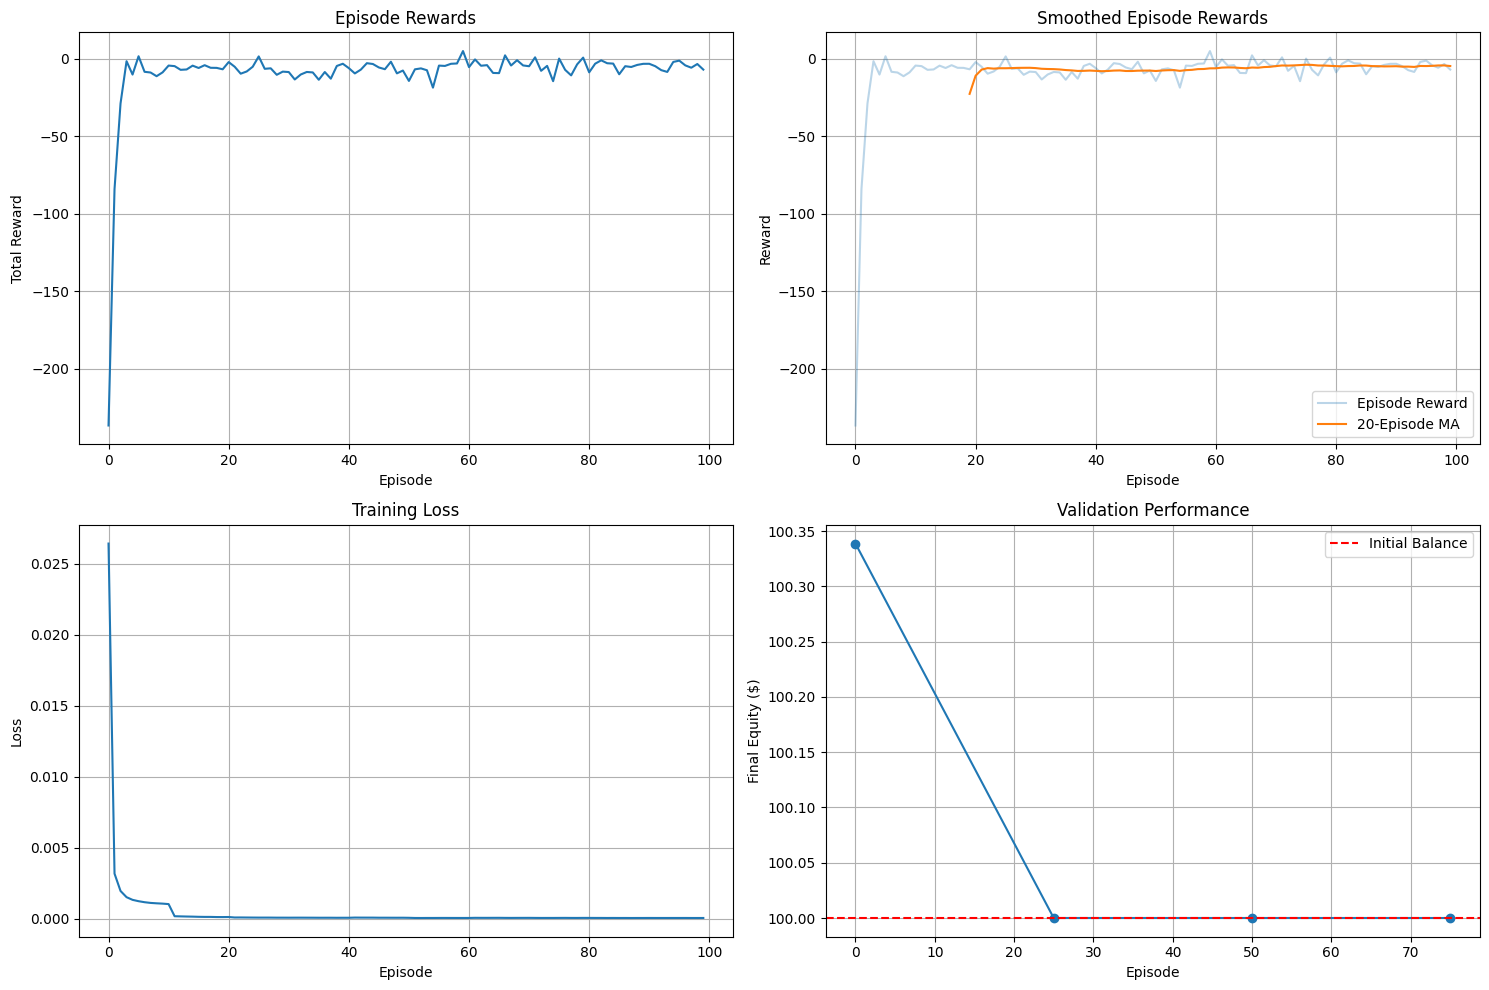


=== Training Summary ===
Total Episodes: 100
Final Episode Reward: -6.932
Average Reward (last 50): -4.919
Best Validation Score: $100.34


In [41]:
def plot_training_results(results):
    """Plot training metrics"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    episodes = range(len(results['episode_rewards']))
    
    # Episode rewards
    ax1.plot(episodes, results['episode_rewards'])
    ax1.set_title('Episode Rewards')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.grid(True)
    
    # Moving average rewards
    window = 20
    if len(results['episode_rewards']) >= window:
        # Use numpy for moving average
        rewards_array = np.array(results['episode_rewards'])
        ma_rewards = np.convolve(rewards_array, np.ones(window)/window, mode='valid')
        ma_episodes = episodes[window-1:]
        
        ax2.plot(episodes, results['episode_rewards'], alpha=0.3, label='Episode Reward')
        ax2.plot(ma_episodes, ma_rewards, label=f'{window}-Episode MA')
        ax2.set_title('Smoothed Episode Rewards')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Reward')
        ax2.legend()
        ax2.grid(True)
    else:
        ax2.plot(episodes, results['episode_rewards'])
        ax2.set_title('Episode Rewards (Insufficient data for MA)')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Reward')
        ax2.grid(True)
    
    # Training losses
    ax3.plot(episodes, results['episode_losses'])
    ax3.set_title('Training Loss')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Loss')
    ax3.grid(True)
    
    # Validation scores
    if results['validation_scores']:
        val_episodes = list(range(0, len(results['episode_rewards']), TEST_EVERY))[:len(results['validation_scores'])]
        ax4.plot(val_episodes, results['validation_scores'], 'o-')
        ax4.axhline(y=100, color='r', linestyle='--', label='Initial Balance')
        ax4.set_title('Validation Performance')
        ax4.set_xlabel('Episode')
        ax4.set_ylabel('Final Equity ($)')
        ax4.legend()
        ax4.grid(True)
    else:
        ax4.text(0.5, 0.5, 'No validation data', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Validation Performance')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n=== Training Summary ===")
    print(f"Total Episodes: {len(results['episode_rewards'])}")
    print(f"Final Episode Reward: {results['episode_rewards'][-1]:.3f}")
    print(f"Average Reward (last 50): {np.mean(results['episode_rewards'][-50:]):.3f}")
    print(f"Best Validation Score: ${results['best_val_score']:.2f}")

plot_training_results(training_results)



## 5.5. Backtest on Test Data

In [42]:
def detailed_backtest(agent, test_env, model_path=None):
    """Comprehensive backtest with detailed analysis"""
    
    if model_path and Path(model_path).exists():
        agent.load(model_path)
        print(f"Loaded model from {model_path}")
    
    # Run backtest
    state = test_env.reset()
    actions_history = []
    rewards_history = []
    equity_history = [test_env.equity]
    positions_history = []
    max_steps = min(len(test_env.data[0]) - 1, 5000)  # จำกัดจำนวน steps
    
    for step in range(max_steps):
        try:
            action = agent.act(state, training=False)
            next_state, reward, done, info = test_env.step(action)
            
            actions_history.append(action)
            rewards_history.append(reward)
            equity_history.append(test_env.equity)
            positions_history.append(test_env.position_type.value)
            
            state = next_state
            
            if done:
                break
        except Exception as e:
            print(f"Error at step {step}: {e}")
            break
    
    # Calculate metrics
    total_return = (test_env.equity / test_env.initial_balance - 1) * 100
    max_equity = max(equity_history) if equity_history else test_env.initial_balance
    min_equity = min(equity_history) if equity_history else test_env.initial_balance
    max_drawdown = (max_equity - min_equity) / max_equity * 100 if max_equity > 0 else 0
    
    # Trade analysis
    closed_trades = [t for t in test_env.trades if 'net_pnl' in t]
    winning_trades = [t for t in closed_trades if t['net_pnl'] > 0]
    losing_trades = [t for t in closed_trades if t['net_pnl'] < 0]
    
    win_rate = len(winning_trades) / len(closed_trades) * 100 if closed_trades else 0
    avg_win = np.mean([t['net_pnl'] for t in winning_trades]) if winning_trades else 0
    avg_loss = np.mean([t['net_pnl'] for t in losing_trades]) if losing_trades else 0
    profit_factor = abs(sum(t['net_pnl'] for t in winning_trades) / 
                       sum(t['net_pnl'] for t in losing_trades)) if losing_trades else float('inf')
    
    # Results
    results = {
        'final_equity': test_env.equity,
        'total_return': total_return,
        'max_drawdown': max_drawdown,
        'total_trades': len(closed_trades),
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'profit_factor': profit_factor,
        'equity_history': equity_history,
        'actions_history': actions_history,
        'positions_history': positions_history
    }
    
    return results

# Run backtest with best model
best_model_path = Path('models') / SYMBOL / 'best_model.pt'
backtest_results = detailed_backtest(agent, test_env, best_model_path)




Loaded model from models\BTCUSDT\best_model.pt


## 5.6. Backtest Analysis & Visualization

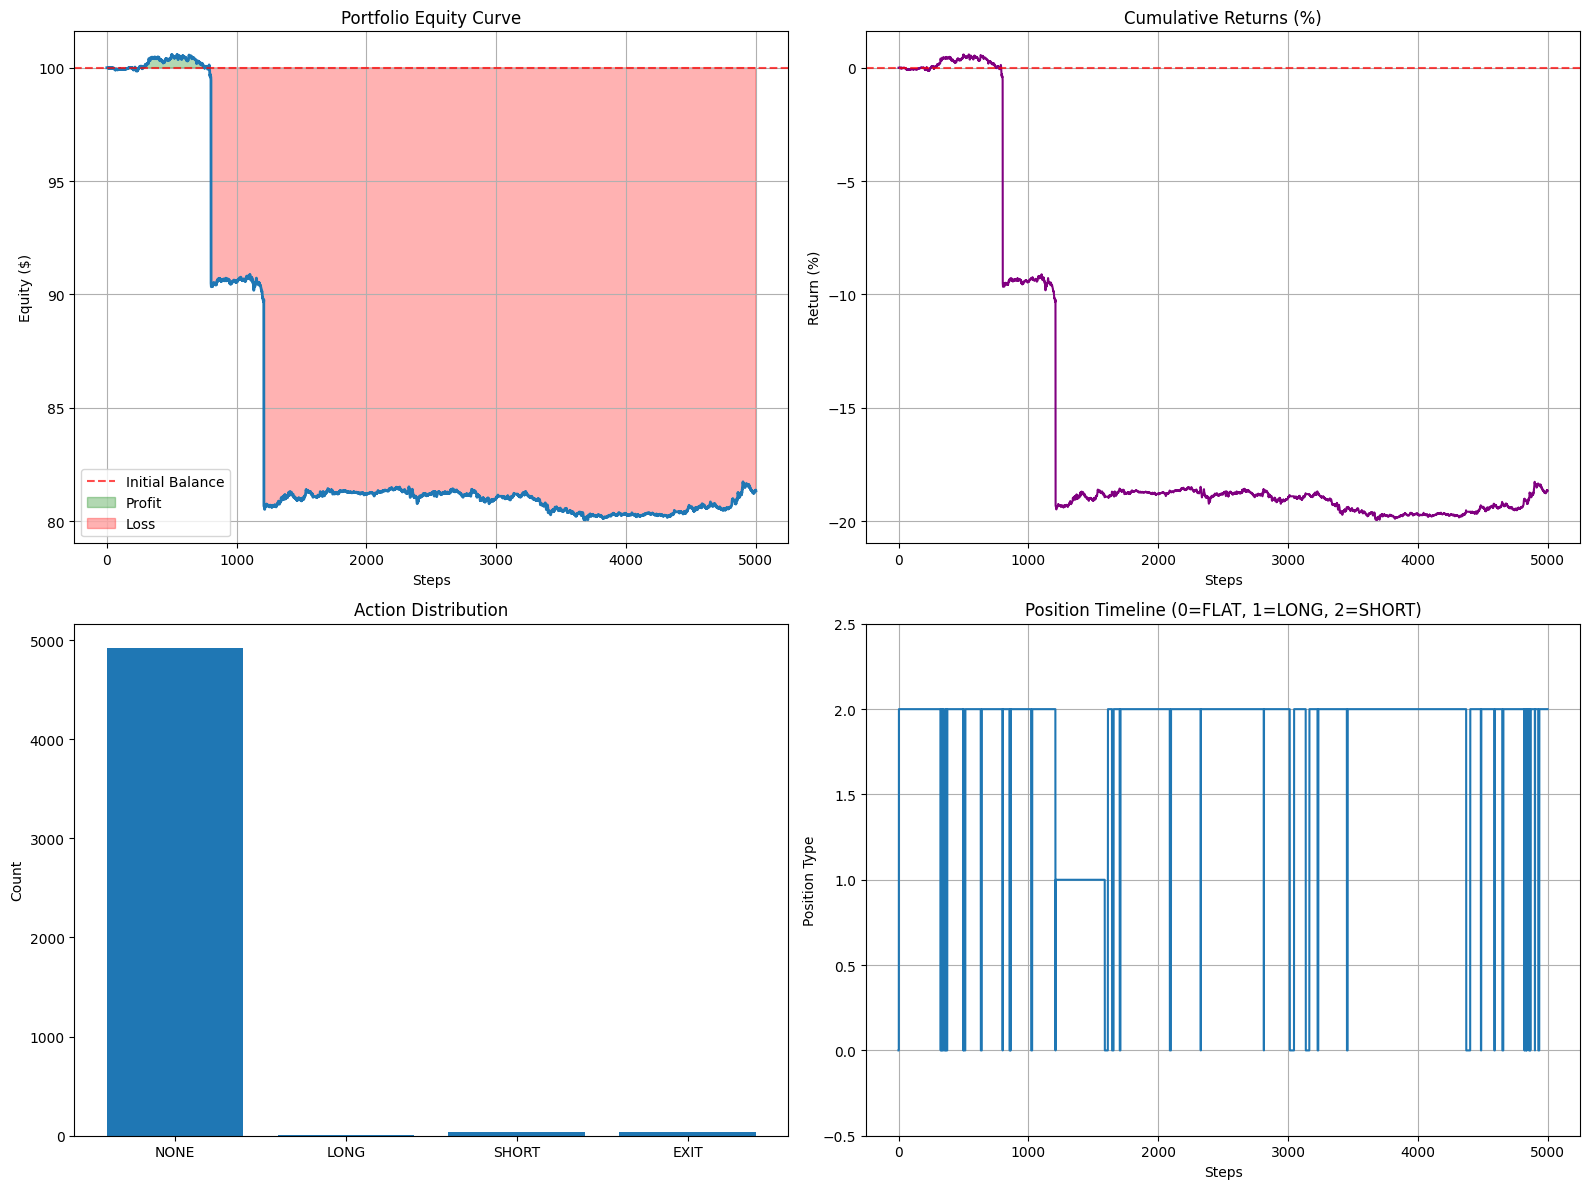

BACKTEST RESULTS SUMMARY
Initial Balance:    $100.00
Final Equity:       $81.33
Total Return:       -18.67%
Max Drawdown:       20.41%
Total Trades:       36
Win Rate:           66.7%
Average Win:        $0.14
Average Loss:       $-1.78
Profit Factor:      0.16
Performance Rating: Negative


In [43]:
def plot_backtest_results(results):
    """Plot comprehensive backtest analysis"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    steps = range(len(results['equity_history']))
    
    # Equity curve
    ax1.plot(steps, results['equity_history'], linewidth=2)
    ax1.axhline(y=100, color='r', linestyle='--', alpha=0.7, label='Initial Balance')
    
    # Fill areas for profit/loss
    equity_array = np.array(results['equity_history'])
    ax1.fill_between(steps, equity_array, 100, 
                     where=equity_array >= 100, 
                     alpha=0.3, color='green', label='Profit')
    ax1.fill_between(steps, equity_array, 100, 
                     where=equity_array < 100, 
                     alpha=0.3, color='red', label='Loss')
    ax1.set_title('Portfolio Equity Curve')
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Equity ($)')
    ax1.legend()
    ax1.grid(True)
    
    # Returns
    returns = [(eq/100 - 1) * 100 for eq in results['equity_history']]
    ax2.plot(steps, returns, color='purple')
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.7)
    ax2.set_title('Cumulative Returns (%)')
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Return (%)')
    ax2.grid(True)
    
    # Action distribution
    action_names = ['NONE', 'LONG', 'SHORT', 'EXIT']
    action_counts = [results['actions_history'].count(i) for i in range(4)]
    ax3.bar(action_names, action_counts)
    ax3.set_title('Action Distribution')
    ax3.set_ylabel('Count')
    
    # Position timeline
    if results['positions_history']:
        pos_steps = range(len(results['positions_history']))
        ax4.plot(pos_steps, results['positions_history'])
        ax4.set_title('Position Timeline (0=FLAT, 1=LONG, 2=SHORT)')
        ax4.set_xlabel('Steps')
        ax4.set_ylabel('Position Type')
        ax4.set_ylim(-0.5, 2.5)
        ax4.grid(True)
    else:
        ax4.text(0.5, 0.5, 'No position data', ha='center', va='center', transform=ax4.transAxes)
    
    plt.tight_layout()
    plt.show()

def print_backtest_summary(results):
    """Print detailed backtest summary"""
    print("=" * 50)
    print("BACKTEST RESULTS SUMMARY")
    print("=" * 50)
    print(f"Initial Balance:    ${100:.2f}")
    print(f"Final Equity:       ${results['final_equity']:.2f}")
    print(f"Total Return:       {results['total_return']:.2f}%")
    print(f"Max Drawdown:       {results['max_drawdown']:.2f}%")
    print(f"Total Trades:       {results['total_trades']}")
    print(f"Win Rate:           {results['win_rate']:.1f}%")
    print(f"Average Win:        ${results['avg_win']:.2f}")
    print(f"Average Loss:       ${results['avg_loss']:.2f}")
    print(f"Profit Factor:      {results['profit_factor']:.2f}")
    
    # Performance rating
    if results['total_return'] > 20:
        rating = "Excellent"
    elif results['total_return'] > 10:
        rating = "Good"
    elif results['total_return'] > 0:
        rating = "Positive"
    else:
        rating = "Negative"
    
    print(f"Performance Rating: {rating}")
    print("=" * 50)

# Display results
plot_backtest_results(backtest_results)
print_backtest_summary(backtest_results)

## 5.7. Save Final Results

In [44]:
# Save final model and results
final_results = {
    'training_results': training_results,
    'backtest_results': {k: v for k, v in backtest_results.items() 
                        if k not in ['equity_history', 'actions_history', 'positions_history']},
    'model_config': {
        'symbol': SYMBOL,
        'episodes_trained': N_EPISODES,
        'final_epsilon': agent.epsilon,
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'gamma': GAMMA
    },
    'timestamp': datetime.now().isoformat()
}

# Save results
results_dir = Path('results') / SYMBOL
results_dir.mkdir(parents=True, exist_ok=True)

results_path = results_dir / 'training_backtest_results.json'
with open(results_path, 'w') as f:
    json.dump(final_results, f, indent=2)

# Save final model
final_model_path = results_dir / 'final_model.pt'
agent.save(final_model_path)

print(f"Results saved to: {results_path}")
print(f"Final model saved to: {final_model_path}")
print(f"\n=== CRYPPO Training & Backtesting Complete ===")
print(f"Total Return: {backtest_results['total_return']:.2f}%")
print(f"Win Rate: {backtest_results['win_rate']:.1f}%")
print(f"Total Trades: {backtest_results['total_trades']}")

Results saved to: results\BTCUSDT\training_backtest_results.json
Final model saved to: results\BTCUSDT\final_model.pt

=== CRYPPO Training & Backtesting Complete ===
Total Return: -18.67%
Win Rate: 66.7%
Total Trades: 36


In [45]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

def plot_candlestick_data(data, n_candles=1000):
    """Plot candlestick chart from training data"""
    
    # Extract price data from first n samples
    X_data = data[0][:n_candles].cpu().numpy()  # Shape: (n, 60, 11)
    
    # Take last timestep of each sequence for OHLC
    price_data = X_data[:, -1, :4]  # Last timestep, first 4 features (log prices)
    
    # Convert from log prices to actual prices
    ohlc_data = np.exp(price_data)
    
    # Create DataFrame
    df = pd.DataFrame(ohlc_data, columns=['Open', 'High', 'Low', 'Close'])
    df['Date'] = pd.date_range(start='2023-01-01', periods=len(df), freq='5T')
    
    # Create candlestick chart
    fig = go.Figure(data=go.Candlestick(
        x=df['Date'],
        open=df['Open'],
        high=df['High'], 
        low=df['Low'],
        close=df['Close'],
        name='BTCUSDT'
    ))
    
    fig.update_layout(
        title='BTCUSDT Candlestick Chart (5min)',
        xaxis_title='Time',
        yaxis_title='Price (USDT)',
        height=600,
        xaxis_rangeslider_visible=False
    )
    
    fig.show()
    
    # Print price statistics
    print(f"Price Range: ${df['Low'].min():.2f} - ${df['High'].max():.2f}")
    print(f"Average Close: ${df['Close'].mean():.2f}")
    print(f"Price Volatility: {df['Close'].std():.2f}")

# Plot the data
plot_candlestick_data((X_train, y_train))

Price Range: $0.13 - $0.14
Average Close: $0.13
Price Volatility: 0.00
